In [2]:
import scanpy as sc
from anndata import read_h5ad
import pandas as pd
import numpy as np
import scipy as sp
import os
import time
import argparse
from statsmodels.stats.multitest import multipletests

# Inhouse tools
import scdrs.util as util
import scdrs.data_loader as dl
import scdrs.method as md



"""
# Fixit


# Todo
- Implement a memory efficient version
- "gene_weight" argument needs to be tested 

# Finished
- Add --n_ctrl (default value 500) 
- Add --cov_file option to regress out covariates stored in COV_FILE before feeding into the score function 
- Add --ctrl_match_opt='mean_var': use mean- and var- matched control genes 
- Change name from scTRS to scdrs (072721)
- Fixed: Warning for compute_score: Trying to set attribute `.X` of view, copying. (did: v_norm_score = v_raw_score.copy())

"""

VERSION='0.0.1'
VERSION='beta'

def convert_species_name(species):
    if species in ['Mouse', 'mouse', 'Mus_musculus', 'mus_musculus', 'mmusculus']:
        return 'mmusculus'
    if species in ['Human', 'human', 'Homo_sapiens', 'homo_sapiens', 'hsapiens']:
        return 'hsapiens'
    raise ValueError('# compute_score: species name %s not supported'%species)
    raise ValueError('# compute_score: species name %s not supported'%species)

# autoreload
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
sys_start_time = time.time()

MASTHEAD = "******************************************************************************\n"
MASTHEAD += "* Single-cell disease relevance score (scDRS)\n"
MASTHEAD += "* Version %s\n"%VERSION
MASTHEAD += "* Martin Jinye Zhang and Kangcheng Hou\n"
MASTHEAD += "* HSPH / Broad Institute / UCLA\n"
MASTHEAD += "* MIT License\n"
MASTHEAD += "******************************************************************************\n"
    
###########################################################################################    
######                                    Parse Options                              ######
###########################################################################################    
H5AD_FILE='/n/holystore01/LABS/price_lab/Users/mjzhang/scDRS_data/simulation_data/single_cell_data/'\
            'tms_facs.ncell_10k.h5ad'
H5AD_SPECIES='mouse'
COV_FILE='/n/holystore01/LABS/price_lab/Users/mjzhang/scDRS_data/tabula_muris_senis/tms_facs.cov'
GS_FILE='/n/holystore01/LABS/price_lab/Users/mjzhang/scDRS_data/gs_file/magma_10kb_1000.74_traits.gs'
GS_SPECIES='human'
CTRL_MATCH_OPT='mean_var'
WEIGHT_OPT='vs'
FLAG_FILTER=True
FLAG_RAW_COUNT=True
N_CTRL=1000
FLAG_RETURN_CTRL_RAW_SCORE=True
FLAG_RETURN_CTRL_NORM_SCORE=True
OUT_FOLDER='/n/holystore01/LABS/price_lab/Users/mjzhang/scDRS_data/score_file/score.schema'

if H5AD_SPECIES!=GS_SPECIES:
        H5AD_SPECIES=convert_species_name(H5AD_SPECIES)
        GS_SPECIES=convert_species_name(GS_SPECIES)
        
header = MASTHEAD
header += 'Call: ./compute_score.py \\\n'
header += '--h5ad_file %s\\\n'%H5AD_FILE
header += '--h5ad_species %s\\\n'%H5AD_SPECIES
header += '--cov_file %s\\\n'%COV_FILE
header += '--gs_file %s\\\n'%GS_FILE
header += '--gs_species %s\\\n'%GS_SPECIES
header += '--ctrl_match_opt %s\\\n'%CTRL_MATCH_OPT
header += '--weight_opt %s\\\n'%WEIGHT_OPT
header += '--flag_filter %s\\\n'%FLAG_FILTER
header += '--flag_raw_count %s\\\n'%FLAG_RAW_COUNT
header += '--n_ctrl %d\\\n'%N_CTRL
header += '--flag_return_ctrl_raw_score %s\\\n'%FLAG_RETURN_CTRL_RAW_SCORE
header += '--flag_return_ctrl_norm_score %s\\\n'%FLAG_RETURN_CTRL_NORM_SCORE
header += '--out_folder %s\n'%OUT_FOLDER
print(header)

# Check options 
if H5AD_SPECIES!=GS_SPECIES:
    if H5AD_SPECIES not in ['mmusculus', 'hsapiens']:
        raise ValueError('--h5ad_species needs to be one of [mmusculus, hsapiens] '
                         'unless --h5ad_species==--gs_species')
    if GS_SPECIES not in ['mmusculus', 'hsapiens']:
        raise ValueError('--gs_species needs to be one of [mmusculus, hsapiens] '
                         'unless --h5ad_species==--gs_species')
if CTRL_MATCH_OPT not in ['mean', 'mean_var']:
    raise ValueError('--ctrl_match_opt needs to be one of [mean, mean_var]')
if WEIGHT_OPT not in ['uniform', 'vs', 'od']:
    raise ValueError('--weight_opt needs to be one of [uniform, vs, inv_std, od]')

******************************************************************************
* Single-cell disease relevance score (scDRS)
* Version beta
* Martin Jinye Zhang and Kangcheng Hou
* HSPH / Broad Institute / UCLA
* MIT License
******************************************************************************
Call: ./compute_score.py \
--h5ad_file /n/holystore01/LABS/price_lab/Users/mjzhang/scDRS_data/simulation_data/single_cell_data/tms_facs.ncell_10k.h5ad\
--h5ad_species mmusculus\
--cov_file /n/holystore01/LABS/price_lab/Users/mjzhang/scDRS_data/tabula_muris_senis/tms_facs.cov\
--gs_file /n/holystore01/LABS/price_lab/Users/mjzhang/scDRS_data/gs_file/magma_10kb_1000.74_traits.gs\
--gs_species hsapiens\
--ctrl_match_opt mean_var\
--weight_opt vs\
--flag_filter True\
--flag_raw_count True\
--n_ctrl 1000\
--flag_return_ctrl_raw_score True\
--flag_return_ctrl_norm_score True\
--out_folder /n/holystore01/LABS/price_lab/Users/mjzhang/scDRS_data/score_file/score.schema



In [4]:
###########################################################################################    
######                                     Load data                                 ######
###########################################################################################
print('Load data:')

# Load .h5ad file 
adata = read_h5ad(H5AD_FILE)
if FLAG_FILTER:
    sc.pp.filter_cells(adata, min_genes=250)
    sc.pp.filter_genes(adata, min_cells=50)
if FLAG_RAW_COUNT:
    sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
    sc.pp.log1p(adata)
print('--h5ad_file loaded: n_cell=%d, n_gene=%d (sys_time=%0.1fs)'
      %(adata.shape[0], adata.shape[1], time.time()-sys_start_time))

# adata = adata[0:500,:].copy()

# Load .cov file and regress out covariates 
if COV_FILE is not None:
    df_cov = pd.read_csv(COV_FILE, sep='\t', index_col=0)
    cov_list = list(df_cov.columns)
    if len(set(df_cov.index) & set(adata.obs_names)) < 0.1*adata.shape[0]:
        raise ValueError('--cov_file does not match the cells in --h5ad_file')
    adata.obs.drop([x for x in cov_list if x in adata.obs.columns], axis=1, inplace=True)
    adata.obs = adata.obs.join(df_cov)
    adata.obs.fillna(adata.obs[cov_list].mean(), inplace=True)
    print('--cov_file loaded: covariates=[%s] (sys_time=%0.1fs)'
          %(', '.join(cov_list), time.time()-sys_start_time))

    adata.var['mean'] = adata.X.mean(axis=0).T
    if sp.sparse.issparse(adata.X):
        adata.X = adata.X.toarray()
    adata.X -= adata.var['mean'].values
    adata.X = md.reg_out(adata.X, adata.obs[cov_list].values)
    adata.X += adata.var['mean']
    print('Regress out covariates from --h5ad_file (sys_time=%0.1fs)'
          %(time.time()-sys_start_time))

# Load .gs file 
df_gs = pd.read_csv(GS_FILE, sep='\t')
df_gs.index = df_gs['TRAIT']
print('--gs_file loaded: n_geneset=%d (sys_time=%0.1fs)'
      %(df_gs.shape[0], time.time()-sys_start_time))

# Convert df_gs genes to H5AD_SPECIES genes
if H5AD_SPECIES!=GS_SPECIES:
#     dirname = os.path.dirname(__file__)
    dirname = '../..'
    df_hom = pd.read_csv(os.path.join(dirname, 'scdrs/data/mouse_human_homologs.txt'), sep='\t')
    if (GS_SPECIES=='hsapiens') & (H5AD_SPECIES=='mmusculus'):
        dic_map = {x:y for x,y in zip(df_hom['HUMAN_GENE_SYM'], df_hom['MOUSE_GENE_SYM'])}
    elif (GS_SPECIES=='mmusculus') & (H5AD_SPECIES=='hsapiens'):
        dic_map = {x:y for x,y in zip(df_hom['MOUSE_GENE_SYM'], df_hom['HUMAN_GENE_SYM'])}
    else:
        raise ValueError('# compute_score: gene conversion from %s to %s is not supported'
                         %(GS_SPECIES, H5AD_SPECIES))

    for trait in df_gs.index:
        gs_gene_list = df_gs.loc[trait, 'GENESET'].split(',')
        h5ad_gene_list = [dic_map[x] for x in set(gs_gene_list) & set(dic_map.keys())]
        df_gs.loc[trait, 'GENESET'] = ','.join(h5ad_gene_list)
    print('--gs_file converted from %s to %s genes (sys_time=%0.1fs)'
          %(GS_SPECIES, H5AD_SPECIES, time.time()-sys_start_time))
print('')

Load data:
--h5ad_file loaded: n_cell=10000, n_gene=16715 (sys_time=2.5s)
--cov_file loaded: covariates=[const, n_genes, sex_male, age] (sys_time=2.8s)
Regress out covariates from --h5ad_file (sys_time=6.9s)
--gs_file loaded: n_geneset=74 (sys_time=6.9s)
--gs_file converted from hsapiens to mmusculus genes (sys_time=7.1s)



In [5]:
np.random.seed(1)
gene_list = list(np.random.choice(adata.var_names, size=1000, replace=False))
df_gs.loc['all_ngene1000'] = ['all_ngene1000', ','.join(gene_list)]

In [6]:
###########################################################################################    
######                                  Computation                                  ######
###########################################################################################

# Compute statistics, including the 20*20 mean-var bins
print('Compute cell-level and gene-level statistics:')
md.compute_stats(adata)
print('')

Compute cell-level and gene-level statistics:



In [7]:
# # Compute score 
# for trait in ['PASS_IBD_deLange2017', 'PASS_Schizophrenia_Pardinas2018',
#               'UKB_460K.biochemistry_Triglycerides', 'all_ngene1000']:
#     gene_list = df_gs.loc[trait,'GENESET'].split(',')
#     gene_list = sorted(set(gene_list) & set(adata.var_names))
#     if len(gene_list)<10:
#         print('trait=%s: skipped due to small size (n_gene=%d, sys_time=%0.1fs)'
#               %(trait, len(gene_list), time.time()-sys_start_time))
#         continue

#     df_res = md.score_cell(adata, gene_list, ctrl_match_key=CTRL_MATCH_OPT, n_ctrl=N_CTRL,
#                            weight_opt=WEIGHT_OPT,
#                            return_ctrl_raw_score=FLAG_RETURN_CTRL_RAW_SCORE, 
#                            return_ctrl_norm_score=FLAG_RETURN_CTRL_NORM_SCORE, verbose=False,
#                            save_intermediate=OUT_FOLDER+'/%s'%trait)
#     df_res.iloc[:,0:6].to_csv(os.path.join(OUT_FOLDER, '%s.score.gz'%trait), sep='\t',
#                               index=True, compression='gzip')
#     if FLAG_RETURN_CTRL_RAW_SCORE|FLAG_RETURN_CTRL_NORM_SCORE:
#         df_res.to_csv(os.path.join(OUT_FOLDER, '%s.full_score.gz'%trait), sep='\t',
#                       index=True, compression='gzip')
#     v_fdr = multipletests(df_res['pval'].values, method='fdr_bh')[1]
#     n_rej_01 = (v_fdr<0.1).sum()
#     n_rej_02 = (v_fdr<0.2).sum()
#     print('Gene set %s (n_gene=%d): %d/%d FDR<0.1 cells, %d/%d FDR<0.2 cells (sys_time=%0.1fs)'
#           %(trait, len(gene_list), n_rej_01, df_res.shape[0], n_rej_02, df_res.shape[0],
#             time.time()-sys_start_time))

In [8]:
# # Compute score (n_ctrl=20000)
# for trait in ['PASS_IBD_deLange2017', 'PASS_Schizophrenia_Pardinas2018',
#               'UKB_460K.biochemistry_Triglycerides', 'all_ngene1000']:
#     gene_list = df_gs.loc[trait,'GENESET'].split(',')
#     gene_list = sorted(set(gene_list) & set(adata.var_names))
#     if len(gene_list)<10:
#         print('trait=%s: skipped due to small size (n_gene=%d, sys_time=%0.1fs)'
#               %(trait, len(gene_list), time.time()-sys_start_time))
#         continue

#     df_res = md.score_cell(adata, gene_list, ctrl_match_key=CTRL_MATCH_OPT, n_ctrl=20000,
#                            weight_opt=WEIGHT_OPT,
#                            return_ctrl_raw_score=False, 
#                            return_ctrl_norm_score=False, verbose=False)
#     df_res.iloc[:,0:6].to_csv(os.path.join(OUT_FOLDER, '%s.nctrl_20k.score.gz'%trait), sep='\t',
#                               index=True, compression='gzip')
#     v_fdr = multipletests(df_res['pval'].values, method='fdr_bh')[1]
#     n_rej_01 = (v_fdr<0.1).sum()
#     n_rej_02 = (v_fdr<0.2).sum()
#     print('Gene set %s (n_gene=%d): %d/%d FDR<0.1 cells, %d/%d FDR<0.2 cells (sys_time=%0.1fs)'
#           %(trait, len(gene_list), n_rej_01, df_res.shape[0], n_rej_02, df_res.shape[0],
#             time.time()-sys_start_time))

In [9]:
OUT_FOLDER

'/n/holystore01/LABS/price_lab/Users/mjzhang/scDRS_data/score_file/score.schema'

### Make figures 

In [40]:
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns

trait_list = ['PASS_IBD_deLange2017', 'PASS_Schizophrenia_Pardinas2018',
              'UKB_460K.biochemistry_Triglycerides', 'all_ngene1000']

dic_plot = {'Raw score': ['raw_score', 'ctrl_raw_score'], 
            'First gene set alignment': ['raw_score.1st_gs_alignment', 'ctrl_raw_score.1st_gs_alignment'], 
            'Cell-wise standardization': ['raw_score.cellwise_standardization',
                                          'ctrl_raw_score.cellwise_standardization'],
            'Second gene set alignment': ['raw_score.2nd_gs_alignment', 'ctrl_raw_score.2nd_gs_alignment'], 
            'Normalized score': ['raw_score.final', 'ctrl_raw_score.final']}

FIG_PATH='/n/holystore01/LABS/price_lab/Users/mjzhang/scDRS_data/results/fig_schema'

DATA_PATH = '/n/holystore01/LABS/price_lab/Users/mjzhang/scDRS_data'
TRAIT_INFO_FILE=DATA_PATH+'/supp_table/trait_info.tsv'
DF_TRAIT_INFO = pd.read_csv(TRAIT_INFO_FILE, sep='\t')
DF_TRAIT_INFO.index = DF_TRAIT_INFO['Trait_Identifier']
DF_TRAIT_INFO.loc['all_ngene1000', 'Code'] = 'R1K'

In [11]:
# Read data 
dic_res = {}
for trait in trait_list:
    dic_res[trait] = pd.read_csv(OUT_FOLDER+'/%s.full_score.gz'%trait, sep='\t', index_col=0)
    dic_res['%s_20k'%trait] = pd.read_csv(OUT_FOLDER+'/%s.nctrl_20k.score.gz'%trait, sep='\t', index_col=0)
    
dic_inter_res = {}
for file in os.listdir(OUT_FOLDER):
    if 'raw_score' in file:
        dic_inter_res[file.replace('.tsv.gz', '')] = np.loadtxt(OUT_FOLDER+'/'+file)

0.954


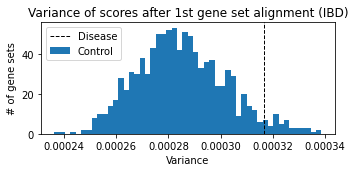

1.0


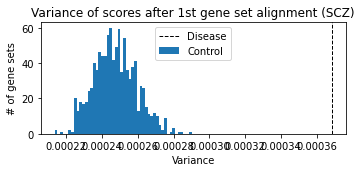

0.987


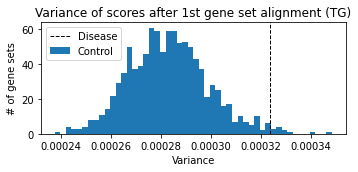

0.225


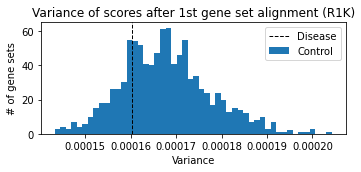

In [41]:
# Variance of scores (after first gene set alignment) 
for trait in trait_list:  
    
    # Variance of raw disease score and control scores 
    plt.figure(figsize=[5,2.5])
    v_ctrl_std = dic_inter_res['%s.%s'%(trait, dic_plot['First gene set alignment'][1])].var(axis=0)
    trait_std = dic_inter_res['%s.%s'%(trait, dic_plot['First gene set alignment'][0])].var()
    print((trait_std>v_ctrl_std).mean())
    plt.hist(v_ctrl_std, bins=50, label='Control')
    ymin,ymax = plt.ylim()
    plt.plot([trait_std, trait_std], [ymin,ymax], 
             linestyle='--', linewidth=1, color='k', label='Disease')
    plt.legend()
    plt.ylim([ymin, ymax])   
    plt.xlabel('Variance')
    plt.ylabel('# of gene sets')
    plt.title('Variance of scores after 1st gene set alignment (%s)'%DF_TRAIT_INFO.loc[trait, 'Code'])
    plt.tight_layout()
    plt.savefig(FIG_PATH+'/var.score_after_1st_gs_alignment.%s.svg'%trait)
    plt.show()

# trait_std=1.78e-02, ctrl_mean_std=1.20e-03, ratio=6.76e-02


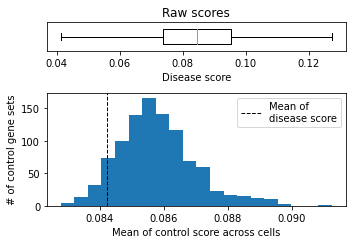

# trait_std=1.78e-02, ctrl_mean_std=1.39e-02, ratio=7.80e-01
# trait_std=1.78e-02, ctrl_std_mean=9.44e-03, ratio=5.30e-01


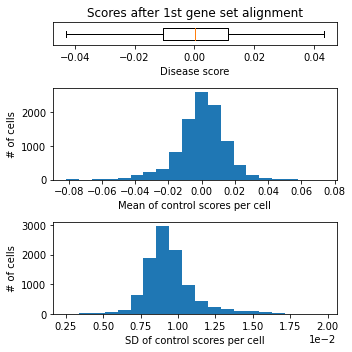

# trait_std=1.28e+00, ctrl_mean_std=1.25e-02, ratio=9.77e-03


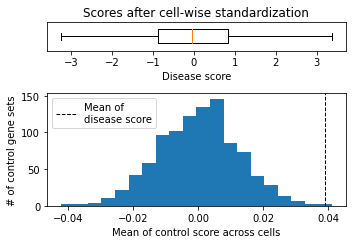

In [42]:
# Figures 
trait = trait_list[0]
    
# Raw score 
term = 'Raw score'
trait_std = dic_inter_res['%s.%s'%(trait, dic_plot[term][0])].std()
ctrl_mean_std = dic_inter_res['%s.%s'%(trait, dic_plot[term][1])].mean(axis=0).std()
print('# trait_std=%0.2e, ctrl_mean_std=%0.2e, ratio=%0.2e'%(trait_std, ctrl_mean_std, ctrl_mean_std/trait_std))
plt.figure(figsize=[5,3.5])
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 4]) 
ax0 = plt.subplot(gs[0])
plt.title('Raw scores')
ax0.boxplot(dic_inter_res['%s.%s'%(trait, dic_plot[term][0])], widths=0.5, vert=False, showfliers=False)
plt.xlabel('Disease score')
plt.yticks([],[])
# plt.xticks([], [])
ax1 = plt.subplot(gs[1])
trait_mean = dic_inter_res['%s.%s'%(trait, dic_plot[term][0])].mean()
v_ctrl_mean = dic_inter_res['%s.%s'%(trait, dic_plot[term][1])].mean(axis=0)
ax1.hist(v_ctrl_mean, bins=20)
ymin,ymax = plt.ylim()
plt.plot([trait_mean, trait_mean], [ymin,ymax], linestyle='--', linewidth=1, 
         color='k', label='Mean of\ndisease score')
# plt.xlim([xmin,xmax])
plt.ylim([ymin,ymax])
plt.legend()
plt.xlabel('Mean of control score across cells')
plt.ylabel('# of control gene sets')
plt.tight_layout()
plt.savefig(FIG_PATH+'/step.raw_score.gs_mean.%s.svg'%trait)
plt.show()

# Effects of First gene set alignment
term = 'First gene set alignment'
trait_std = dic_inter_res['%s.%s'%(trait, dic_plot[term][0])].std()
ctrl_mean_std = dic_inter_res['%s.%s'%(trait, dic_plot[term][1])].mean(axis=1).std()
print('# trait_std=%0.2e, ctrl_mean_std=%0.2e, ratio=%0.2e'%(trait_std, ctrl_mean_std, ctrl_mean_std/trait_std))
trait_std = dic_inter_res['%s.%s'%(trait, dic_plot[term][0])].std()
ctrl_std_mean = dic_inter_res['%s.%s'%(trait, dic_plot[term][1])].std(axis=1).mean()
print('# trait_std=%0.2e, ctrl_std_mean=%0.2e, ratio=%0.2e'%(trait_std, ctrl_std_mean, ctrl_std_mean/trait_std))
plt.figure(figsize=[5,5])
gs = gridspec.GridSpec(3, 1, height_ratios=[1, 4, 4]) 
ax0 = plt.subplot(gs[0])
plt.title('Scores after 1st gene set alignment')
ax0.boxplot(dic_inter_res['%s.%s'%(trait, dic_plot[term][0])], widths=0.5, vert=False, showfliers=False)
xmin,xmax = plt.xlim()
plt.xlabel('Disease score')
plt.yticks([],[])
ax1 = plt.subplot(gs[1])
v_ctrl_mean_percell = dic_inter_res['%s.%s'%(trait, dic_plot[term][1])].mean(axis=1)
ax1.hist(v_ctrl_mean_percell, bins=20)
plt.xlabel('Mean of control scores per cell')
plt.ylabel('# of cells')
ax2 = plt.subplot(gs[2])
v_ctrl_sd_percell = dic_inter_res['%s.%s'%(trait, dic_plot[term][1])].std(axis=1)
ax2.hist(v_ctrl_sd_percell, bins=20)
ax2.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.xlabel('SD of control scores per cell')
plt.ylabel('# of cells')
plt.tight_layout()
plt.savefig(FIG_PATH+'/step.score_after_1st_gs_alignment.cellwise_stats.%s.svg'%trait)
plt.show()


# Cell-wise standardization
term = 'Cell-wise standardization'
trait_std = dic_inter_res['%s.%s'%(trait, dic_plot[term][0])].std()
ctrl_mean_std = dic_inter_res['%s.%s'%(trait, dic_plot[term][1])].mean(axis=0).std()
print('# trait_std=%0.2e, ctrl_mean_std=%0.2e, ratio=%0.2e'%(trait_std, ctrl_mean_std, ctrl_mean_std/trait_std))
plt.figure(figsize=[5,3.5])
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 4]) 
ax0 = plt.subplot(gs[0])
plt.title('Scores after cell-wise standardization')
ax0.boxplot(dic_inter_res['%s.%s'%(trait, dic_plot[term][0])], widths=0.5, vert=False, showfliers=False)
plt.xlabel('Disease score')
plt.yticks([],[])
ax1 = plt.subplot(gs[1])
trait_mean = dic_inter_res['%s.%s'%(trait, dic_plot[term][0])].mean()
v_ctrl_mean = dic_inter_res['%s.%s'%(trait, dic_plot[term][1])].mean(axis=0)
ax1.hist(v_ctrl_mean, bins=20)
ymin,ymax = plt.ylim()
plt.plot([trait_mean, trait_mean], [ymin,ymax], linestyle='--', linewidth=1, 
         color='k', label='Mean of\ndisease score')
# plt.xlim([xmin,xmax])
plt.ylim([ymin, ymax])
plt.legend(loc='upper left')
plt.xlabel('Mean of control score across cells')
plt.ylabel('# of control gene sets')
plt.tight_layout()
plt.savefig(FIG_PATH+'/step.score_after_cw_std.gs_mean.%s.svg'%trait)
plt.show()

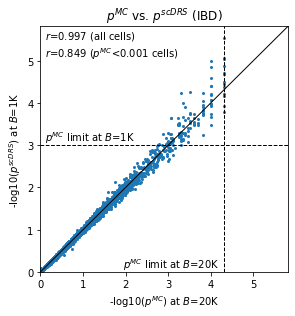

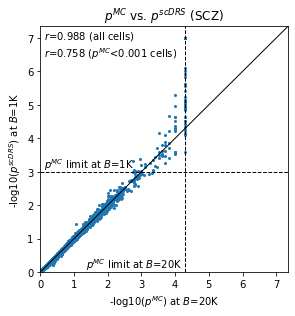

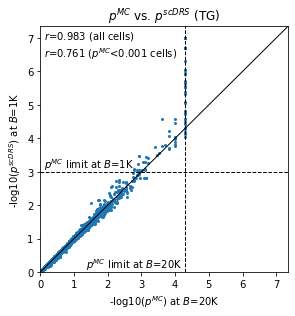

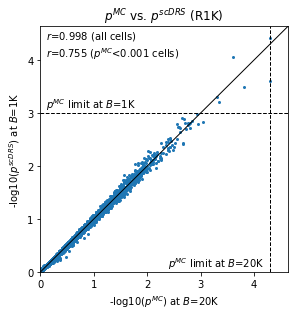

In [43]:
# Validations mc_pval vs. pval
for trait in trait_list:  
    
    # Consistency between mc_pval and pval
    plt.figure(figsize=[4.2,4.5])
    v_mc_p = dic_res['%s_20k'%trait]['mc_pval']
    v_pooled_p = dic_res[trait]['pval']
    plt.scatter(-np.log10(v_mc_p), -np.log10(v_pooled_p), s=4)
    xmin,xmax = plt.xlim()
    ymin,ymax = plt.ylim()
    xmin,ymin = 0,0
    min_,max_ = min(xmin,ymin), max(xmax,ymax)
    plt.plot([min_,max_], [min_,max_], linestyle='-', linewidth=1, color='k')
    plt.plot([min_,max_], [-np.log10(1/1001),-np.log10(1/1001)], linestyle='--', linewidth=1, color='k')
    plt.text(0.1, -np.log10(1/1001)+0.1, '$p^{MC}$ limit at $B$=1K')
    plt.plot([-np.log10(1/20001),-np.log10(1/20001)], [min_,max_], linestyle='--', linewidth=1, color='k')
    plt.text(-np.log10(1/20001)-0.1, 0.1, '$p^{MC}$ limit at $B$=20K', ha='right')
    plt.xlim([min_, max_])   
    plt.ylim([min_, max_])   
    plt.xlabel('-log10($p^{MC}$) at $B$=20K')
    plt.ylabel('-log10($p^{scDRS}$) at $B$=1K')
    corr_ = np.corrcoef(-np.log10(v_mc_p), -np.log10(v_pooled_p))[0,1]    
    ind_select = (v_mc_p<1/1000)
    corr_extra = np.corrcoef(-np.log10(v_mc_p[ind_select]), -np.log10(v_pooled_p[ind_select]))[0,1]  
    plt.text(0.1, ymax-0.05*(ymax-ymin), '$r$=%0.3f (all cells)'%corr_)
    plt.text(0.1, ymax-0.125*(ymax-ymin), '$r$=%0.3f ($p^{MC}$<0.001 cells)'%corr_extra)
    plt.title('$p^{MC}$ vs. $p^{scDRS}$ (%s)'%(DF_TRAIT_INFO.loc[trait, 'Code']))
    plt.tight_layout()
    plt.savefig(FIG_PATH+'/mcp_vs_p.%s.svg'%trait)
    plt.show()